In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import cv2
from tqdm import tqdm

dataset_path = "../CIFAR-10-images/train"
CATEGORIES=[]

for c in os.listdir(dataset_path):
	CATEGORIES.append(c)

print(CATEGORIES) #10 classes for CIFAR 10




['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [2]:
train_data=[]
for c in CATEGORIES: #this allows movement through glasses and noglasses due to folder items
	path = os.path.join(dataset_path, c)
	class_num = CATEGORIES.index(c) #Category index 0 = glasses, 1 = noglasses hence we will have a class attached to data
	for img in tqdm(os.listdir(path)):
		try:
			img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE) #without color
			img_resize = cv2.resize(img_arr, (32,32)) #this is for resizing to standard		
			train_data.append([img_resize, class_num])
		except Exception as e:
			pass
print(len(train_data))

100%|██████████| 5000/5000 [00:00<00:00, 6925.77it/s]

50000


In [3]:
random.shuffle(train_data) #randomizes the data but the list inside list are not shuffled hence classes are okay
for sample in train_data[:11]:
	print(sample[1])


3
0
0
2
9
0
4
8
0
0
7


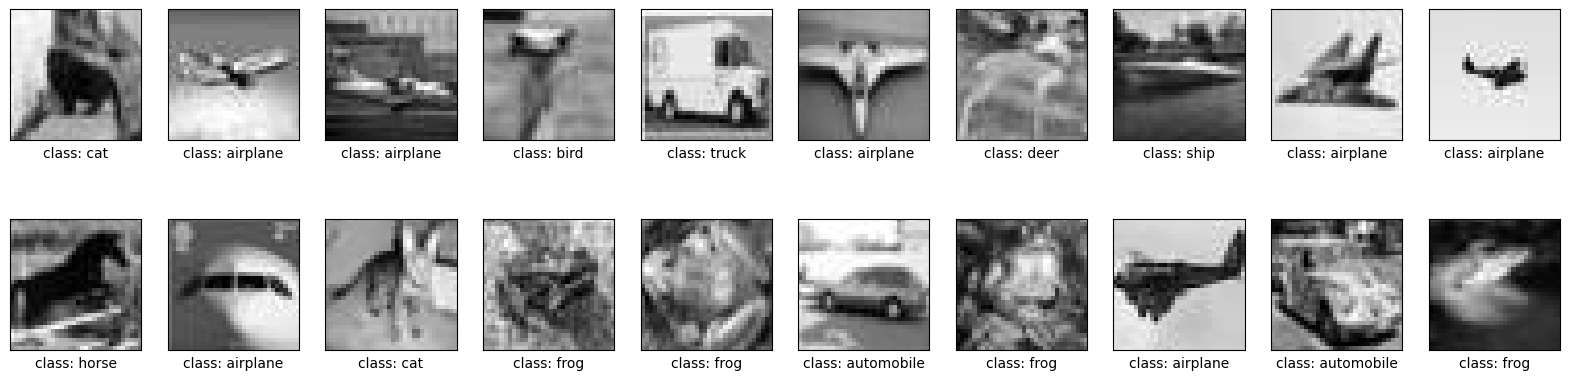

In [4]:
plt.figure(figsize=(20,5)) #this would show 20 images but we'll use one figure
for i in range(20):
	plt.subplot(2,10,i+1) #i+1 used because our friend matlab starts indexing from 1
	plt.imshow(train_data[i][0], cmap="gray")
	plt.xticks([])
	plt.yticks([])
	plt.xlabel(f"class: {CATEGORIES[train_data[i][1]]}") #denotes the class of the image
plt.show()


In [5]:
#KNN K-Fold 5-Fold
f0 = train_data[0:1000]
f1 = train_data[1000:2000]
f2 = train_data[2000:3000]
f3 = train_data[3000:4000]
f4 = train_data[4000:5000]


In [6]:
folds = [f0, f1, f2, f3, f4]

# Define the k-NN function
def knn(train_data, test_data, k, distance_metric):
    predictions = []
    for test_image, test_label in test_data:
        distances = []
        for train_image, train_label in train_data:
            if distance_metric == 'Manhattan':
                distance = np.sum(np.abs(test_image - train_image))
            elif distance_metric == 'Euclidean':
                distance = np.sqrt(np.sum(np.square(test_image - train_image)))
            distances.append((distance, train_label))
        
        distances.sort(key=lambda x: x[0])  # Sort distances in ascending order
        neighbors = distances[:k]  # Select the k nearest neighbors
        
        # Count the occurrences of each class among the neighbors
        class_count = np.zeros(len(CATEGORIES))
        for _, label in neighbors:
            class_count[label] += 1
        
        # Determine the predicted class based on the majority vote
        predicted_class = np.argmax(class_count)
        predictions.append(predicted_class)
    
    return predictions

In [7]:

# Define the evaluation function
def evaluate_model(train_data, test_data, k, distance_metric):
    y_true = [label for _, label in test_data]
    y_pred = knn(train_data, test_data, k, distance_metric)
    
    accuracy = np.sum(np.array(y_true) == np.array(y_pred)) / len(y_true)
    return accuracy


In [8]:


# Perform 5-fold cross-validation
k_values = [1, 3, 5, 7]  # Hyperparameter values of k
accuracy_scores_manhattan = []
accuracy_scores_euclidean = []

for k in k_values:
    fold_accuracies_manhattan = []
    fold_accuracies_euclidean = []
    
    for i in range(5):
        train_data_fold = folds[:i] + folds[i+1:]  # Use 4 folds for training
        train_data_fold = [item for fold in train_data_fold for item in fold]  # Flatten the list
        test_data_fold = folds[i]  # Use 1 fold for testing
        
        accuracy_manhattan = evaluate_model(train_data_fold, test_data_fold, k, 'Manhattan')
        accuracy_euclidean = evaluate_model(train_data_fold, test_data_fold, k, 'Euclidean')
        
        fold_accuracies_manhattan.append(accuracy_manhattan)
        fold_accuracies_euclidean.append(accuracy_euclidean)
    
    average_accuracy_manhattan = np.mean(fold_accuracies_manhattan)
    average_accuracy_euclidean = np.mean(fold_accuracies_euclidean)
    
    accuracy_scores_manhattan.append(average_accuracy_manhattan)
    accuracy_scores_euclidean.append(average_accuracy_euclidean)



In [9]:
print(average_accuracy_manhattan)
print(average_accuracy_euclidean)
print(accuracy_scores_manhattan)
print(accuracy_scores_euclidean)

0.18580000000000002
0.15
[0.1854, 0.1752, 0.184, 0.18580000000000002]
[0.1538, 0.14240000000000003, 0.1478, 0.15]


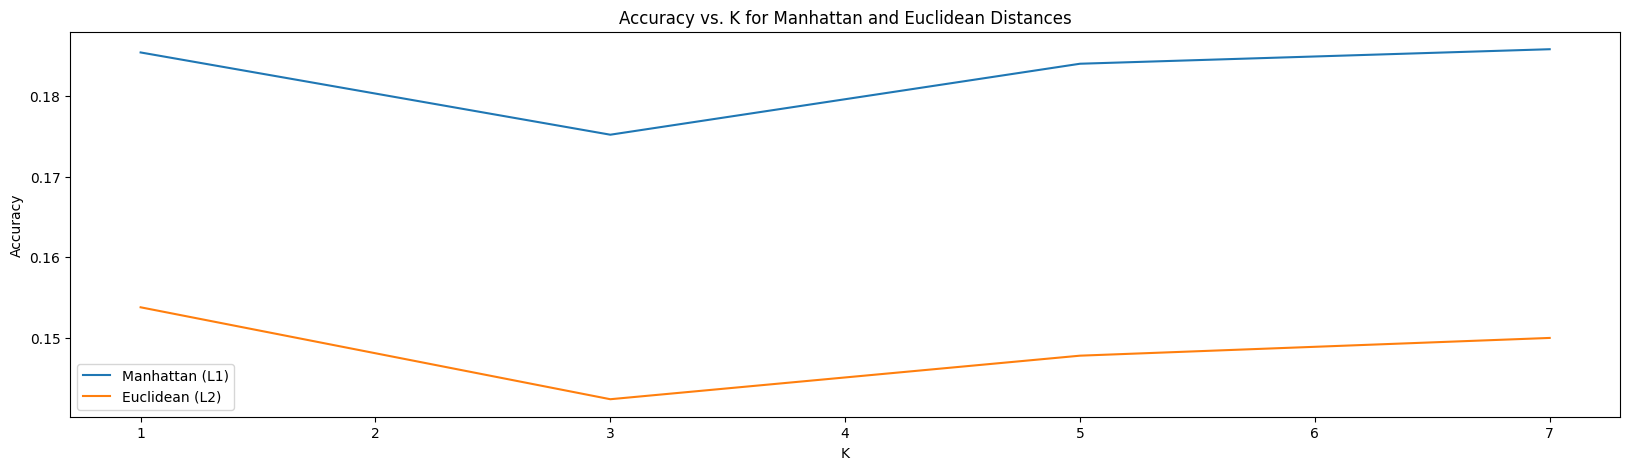

In [10]:
# Plot the graph
plt.figure(figsize=(20,5))
plt.errorbar(k_values, accuracy_scores_manhattan, label='Manhattan (L1)')
plt.errorbar(k_values, accuracy_scores_euclidean, label='Euclidean (L2)')
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. K for Manhattan and Euclidean Distances')
plt.legend()
plt.show()


In [11]:
# Define the path to the test dataset
test_dataset_path = "CIFAR-10-images/test"
test_data = []

# Load and preprocess the test images
for c in CATEGORIES:
    path = os.path.join(test_dataset_path, c)
    class_num = CATEGORIES.index(c)
    for img in tqdm(os.listdir(path)):
        try:
            img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
            img_resize = cv2.resize(img_arr, (32, 32))
            test_data.append([img_resize, class_num])
        except Exception as e:
            pass

# Choose a value of k for predictions
k = 5

# Initialize an empty list to store the predictions for the test images
test_predictions = []

# Perform predictions on the test images
for test_image in test_data:
    test_img = test_image[0]
    pred = knn(train_data, [(test_img, 0)], k,"Manhattan")
    test_predictions.append(pred[0])

# Display the top 5 predictions for each test image
for i in range(len(test_data)):
    test_img = test_data[i][0]
    true_class = test_data[i][1]
    predictions = test_predictions[i]
    
    # Show the test image
    plt.imshow(test_img, cmap='gray')
    plt.axis('off')
    plt.title('Test Image')
    plt.show()
    
    # Show the top 5 predictions
    print('True Class:', CATEGORIES[true_class])
    print('Top 5 Predictions:')
    for j in range(5):
        pred_class = CATEGORIES[predictions[j]]
        print(f'{j+1}. {pred_class}')
    print('-' * 30)


100%|██████████| 1000/1000 [00:00<00:00, 7417.53it/s]
